In [38]:
# Import all necessary libraries. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import keras as keras
from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.linear_model import Perceptron, SGDClassifier
import tensorflow as tf
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import keras_tuner as kt

In [2]:
# We construct a simple Perceptron class with the Sci-Kit Learn library with the Iris dataset. 

IMAGES_PATH = Path() / "images" / "ann" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)
y_pred

array([ True, False])

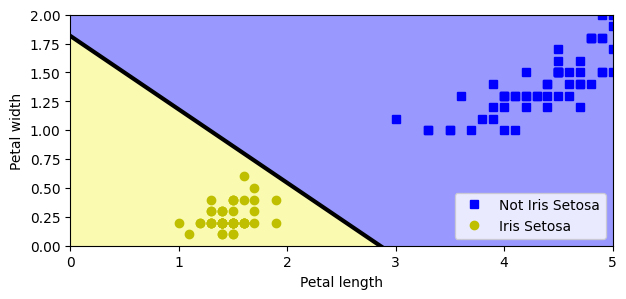

In [3]:
# Note that a Perceptron is equivalent to a SGDClassifier with the loss function set to "perceptron" with no regularization and 
# a constant learning rate of 1. Below is an implementation and plot of the resulting decision boundaries. 

sgd_clf = SGDClassifier(loss="perceptron", penalty=None, learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris Setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris Setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a *axes[1] + b], "k-", linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()


In [4]:
# We now construct a regression Multi-Layer Perceptron on the CA Housing dataset for predictions and use the root mean squared
# error as a performance metric for our model. 

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42
)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
rmse

0.5053326657968716

In [5]:
# We now create an MLP Classifier for the Iris dataset.

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

In [3]:
# We now build an image classifier using the Sequential API with Keras and Tensorflow. We will use the Fashion MNISt dataset. 

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
print(X_train.shape)
print(X_train.dtype)

(55000, 28, 28)
uint8


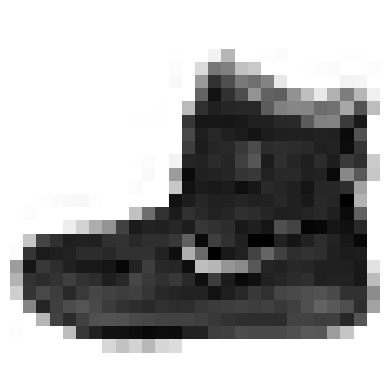

In [4]:
# Take a peek at an image from the Fashion Mnist dataset. 

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [5]:
# Scale the pixel intensities down to 0-1 range by dividing them by 255.0. Confirm that the first image is an ankle boot.

X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255. 
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

class_names[y_train[0]]

'Ankle boot'

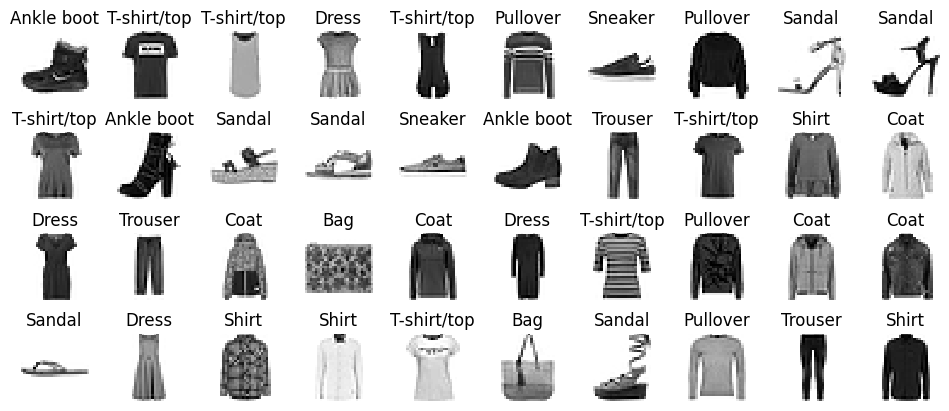

In [6]:
# Take a look at a sample of the images from the dataset. 

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [10]:
# We now create the model using Sequential API. This is the line by line syntax.

tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [7]:
# Clear the session and show the embedded way of passing layers as parameters through the Sequential model. 

tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.summary()

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

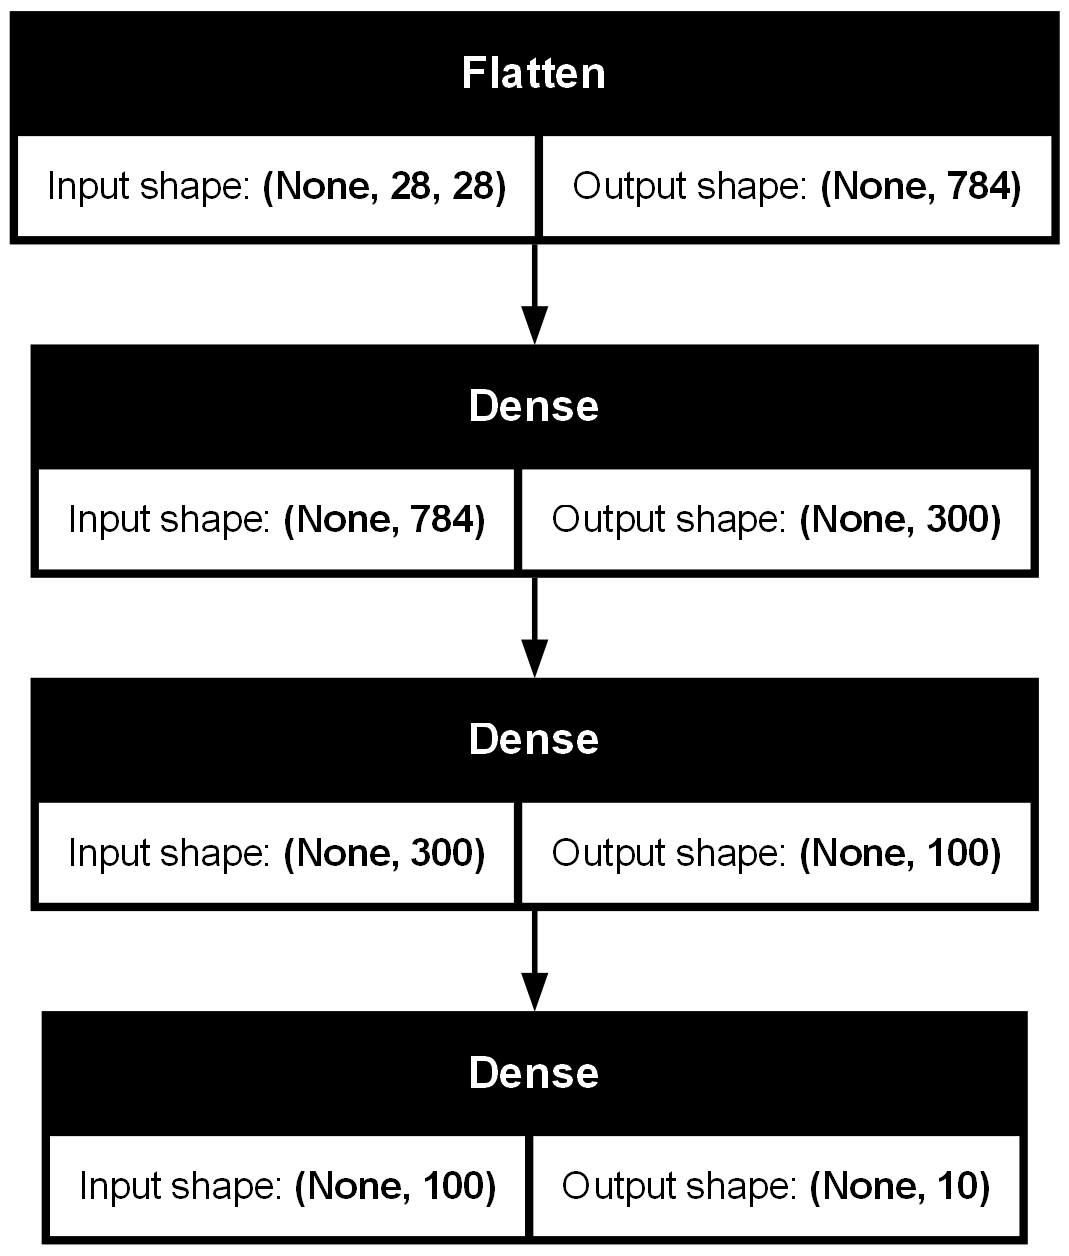

In [8]:
# We can display the model's architecture as so. 
import os
os.environ["PATH"] += os.pathsep + 'C://Users/coryg/OneDrive/Desktop/Graphviz/bin'

tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [9]:
# We can also retrieve the weights and biases of a layer within the model, we retrieve the first hidden layer's weights and
# biases. 

hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
weights

array([[ 0.02032597,  0.04148793,  0.05591853, ..., -0.03855963,
         0.01954038, -0.00993462],
       [ 0.00551757,  0.05228491, -0.07212795, ..., -0.0564703 ,
        -0.00596441,  0.07232277],
       [-0.05840861,  0.06064323, -0.01069722, ...,  0.06772728,
        -0.05074771, -0.00162653],
       ...,
       [-0.00480678,  0.02447324, -0.00682345, ...,  0.03265184,
        -0.04822279, -0.05873942],
       [ 0.02315927,  0.01510859, -0.07191928, ...,  0.02278271,
         0.01920529, -0.01455137],
       [ 0.02442116, -0.02321378,  0.05580571, ...,  0.04058371,
        -0.02425167, -0.06942965]], dtype=float32)

In [10]:
# Now for the biases of the model. 

biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [8]:
# Now we compile the model using the sparse categorical cross-entropy loss function and the SGD optimizer with accuracy as our
# performance metric. 

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [9]:
# We now train and evaluate the model. 

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6759 - loss: 1.0107 - val_accuracy: 0.8254 - val_loss: 0.5174
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8216 - loss: 0.5159 - val_accuracy: 0.8348 - val_loss: 0.4636
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8387 - loss: 0.4590 - val_accuracy: 0.8434 - val_loss: 0.4382
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8493 - loss: 0.4272 - val_accuracy: 0.8478 - val_loss: 0.4213
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8580 - loss: 0.4047 - val_accuracy: 0.8514 - val_loss: 0.4096
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8647 - loss: 0.3871 - val_accuracy: 0.8552 - val_loss: 0.3998
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8695 - loss: 0.3726 - val_accuracy: 0.8562 - val_loss: 0.3946
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8721 - loss: 0.3600 - 

In [10]:
# Check the parameters in the history of the model's training epochs.

history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}

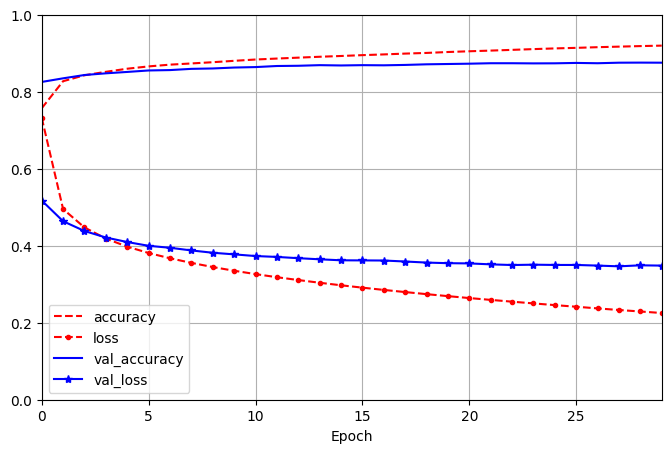

In [11]:
# Plot the learning curves of loss and accuracy of the model. 

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"]
)
plt.legend(loc="lower left")
plt.show()

In [12]:
# Let us take a look at the loss and sparse categorical accuracy of the model. 

model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8754 - loss: 0.3643


[0.36304959654808044, 0.8744000196456909]

In [13]:
# And now use that same model to make prtedictions on new instances. 

X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.01, 0.  , 0.78],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [14]:
# We can get the highest probability class index for each instance. 

y_pred = y_proba.argmax(axis=-1)
print(y_pred)
np.array(class_names)[y_pred]

[9 2 1]


array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

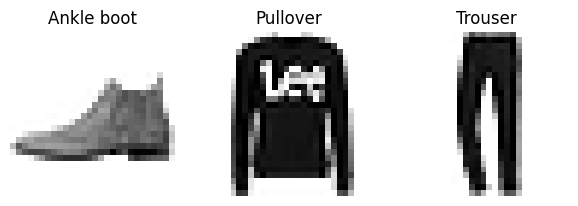

In [15]:
# Now we can plot these correct classifications and show the images classified. 

plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [16]:
# Now we build a Regression MLP using the Sequential API. 

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42
)

tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20


c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - RootMeanSquaredError: 1.2712 - loss: 1.7469 - val_RootMeanSquaredError: 0.6177 - val_loss: 0.3816
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6349 - loss: 0.4035 - val_RootMeanSquaredError: 0.8516 - val_loss: 0.7253
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6103 - loss: 0.3728 - val_RootMeanSquaredError: 0.5753 - val_loss: 0.3309
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5957 - loss: 0.3551 - val_RootMeanSquaredError: 1.0133 - val_loss: 1.0269
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5854 - loss: 0.3430 - val_RootMeanSquaredError: 1.2975 - val_loss: 1.6834
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5783 - loss: 0.3345 - val_RootMeanSquaredError: 1.3898 - val_loss: 1.9316
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5722 - loss: 0.3276 -

In [17]:
# Check the RMSE and predictions on the new instances. 

print(rmse_test)
print(y_pred)

0.5376061201095581
[[0.46962318]
 [1.5696338 ]
 [4.966183  ]]


In [18]:
# Sequential models can be limited in that they force data through the network layers sequentially, however the Functional API
# offers a more flexible neural network that can include multiple complex topologies such as multiple inputs and multiple outputs
# processing. We build a wide and deep NN using the Functional API on the CA Housing dataset. 

tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [19]:
# Continued from above cell. 
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 8)         │         17 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30)        │        270 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │        930 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

In [21]:
optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - RootMeanSquaredError: 1.3592 - loss: 1.9459 - val_RootMeanSquaredError: 0.8886 - val_loss: 0.7897
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.7136 - loss: 0.5110 - val_RootMeanSquaredError: 0.6637 - val_loss: 0.4405
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6442 - loss: 0.4155 - val_RootMeanSquaredError: 0.6150 - val_loss: 0.3783
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6217 - loss: 0.3868 - val_RootMeanSquaredError: 0.5894 - val_loss: 0.3474
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6082 - loss: 0.3702 - val_RootMeanSquaredError: 0.5787 - val_loss: 0.3349
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5997 - loss: 0.3599 - val_RootMeanSquaredError: 0.5733 - val_loss: 0.3286
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5935 - los

In [22]:
# Now if we want to send different subsets of input features through the wide or deep paths of choice, we can do so by specifying
# which input features go where in the deep and wide NN. Here, features 0-4 and 6 will go to the deep path and 2,3,4 will go to
# both. 

tf.random.set_seed(42)

input_wide = tf.keras.layers.Input(shape=[5])      # features 0-4
input_deep = tf.keras.layers.Input(shape=[6])      # features 2-7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - RootMeanSquaredError: 1.4761 - loss: 2.3010 - val_RootMeanSquaredError: 0.9217 - val_loss: 0.8496
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.7230 - loss: 0.5235 - val_RootMeanSquaredError: 0.6616 - val_loss: 0.4378
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6673 - loss: 0.4456 - val_RootMeanSquaredError: 0.6386 - val_loss: 0.4079
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6474 - loss: 0.4194 - val_RootMeanSquaredError: 0.6069 - val_loss: 0.3684
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6364 - loss: 0.4052 - val_RootMeanSquaredError: 0.6005 - val_loss: 0.3607
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6266 - loss: 0.3929 - val_RootMeanSquaredError: 0.6011 - val_loss: 0.3613
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6185 - los

In [24]:
# We can also add an auxiliary output for regularization of the NN. 

tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [25]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output, aux_output])

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError", "RootMeanSquaredError"])

In [27]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - dense_2_RootMeanSquaredError: 1.6180 - dense_2_loss: 2.4751 - dense_3_RootMeanSquaredError: 2.3944 - dense_3_loss: 0.5841 - loss: 3.0592 - val_dense_2_RootMeanSquaredError: 0.7581 - val_dense_2_loss: 0.5171 - val_dense_3_RootMeanSquaredError: 2.5735 - val_dense_3_loss: 0.6620 - val_loss: 1.1795
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - dense_2_RootMeanSquaredError: 0.7439 - dense_2_loss: 0.4990 - dense_3_RootMeanSquaredError: 1.1572 - dense_3_loss: 0.1341 - loss: 0.6332 - val_dense_2_RootMeanSquaredError: 0.8335 - val_dense_2_loss: 0.6251 - val_dense_3_RootMeanSquaredError: 1.0998 - val_dense_3_loss: 0.1209 - val_loss: 0.7463
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - dense_2_RootMeanSquaredError: 0.6769 - dense_2_loss: 0.4126 - dense_3_RootMeanSquaredError: 0.9093 - dense_3_loss: 0.0828 - loss: 0.4954 - val_dense_2_RootMeanSquaredError: 0.8083 - val_dense_2_loss: 0.5878 - val_dense_3_RootMeanSquaredError: 0.8

In [33]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - dense_2_RootMeanSquaredError: 0.5847 - dense_2_loss: 0.3078 - dense_3_RootMeanSquaredError: 0.6349 - dense_3_loss: 0.0403 - loss: 0.3481


In [31]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


In [32]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [34]:
# We can also use the Subclassing API to build dynamic NN models with Keras. 

class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)

    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output
    
model = WideAndDeepModel(30, activation="relu", name="my_deep_and_wide_model")

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics = ["RootMeanSquaredError", "RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - RootMeanSquaredError: 1.7224 - RootMeanSquaredError_1: 1.7302 - loss: 3.0711 - mse_loss: 0.3081 - val_RootMeanSquaredError: 0.8516 - val_RootMeanSquaredError_1: 1.2265 - val_loss: 0.8031 - val_mse_loss: 0.1504
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.8013 - RootMeanSquaredError_1: 0.8493 - loss: 0.6508 - mse_loss: 0.0722 - val_RootMeanSquaredError: 0.7340 - val_RootMeanSquaredError_1: 0.8451 - val_loss: 0.5563 - val_mse_loss: 0.0714
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.7108 - RootMeanSquaredError_1: 0.7633 - loss: 0.5132 - mse_loss: 0.0583 - val_RootMeanSquaredError: 0.6533 - val_RootMeanSquaredError_1: 0.7586 - val_loss: 0.4416 - val_mse_loss: 0.0575
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.6661 - RootMeanSquaredError_1: 0.7313 - loss: 0.4530 - mse_loss: 0.0535 - val_RootMeanSquaredError: 0.6473 - val_RootMeanSquaredEr

In [36]:
# We can also fine-tune NN hyperparameters due to the nonlinear nature of learning that the NN introduces into the model. We will
# be using the keras_tuner library to tune NN hyperparameters. 

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [37]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [46]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [48]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42
)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 51s]
val_accuracy: 0.8216000199317932

Best val_accuracy So Far: 0.8565999865531921
Total elapsed time: 00h 05m 59s


In [49]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [50]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [51]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8565999865531921


In [53]:
best_trial.metrics.get_last_value("val_accuracy")

0.8565999865531921

In [54]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8754 - loss: 0.3330
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8795 - loss: 0.3232
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8834 - loss: 0.3120
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8881 - loss: 0.3025
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8905 - loss: 0.2953
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8936 - loss: 0.2875
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8959 - loss: 0.2797
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8987 - loss: 0.2729
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9013 - loss: 0.2676
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9031 - loss: 0.2620
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8600 - loss: 0.4239


In [55]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)
    
    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [65]:
# Note: Training without the callbacks takes a substantial amount of time, so the code is here for demonstration 
# purposes on how to perform hyperband hyperparameter tuning for neural networks.

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)

hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=2, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband"
)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb])

In [59]:
# We can also implement a Bayesian Optimization Tuner to achieve hyperparameter tuning. 

bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt"
)
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid))

Trial 10 Complete [00h 00m 52s]
val_accuracy: 0.8334000110626221

Best val_accuracy So Far: 0.855400025844574
Total elapsed time: 00h 09m 41s
